In [21]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
from time import sleep
from plotly.subplots import make_subplots
from torch.utils.data import DataLoader
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from utils.training import validate_epoch, train_epoch
from utils.dataset_generator import YuGiOhDatasetDataFrame
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cpu


In [23]:
df = pd.read_csv('db\\dados_cartas_yugioh.csv', encoding='utf-8')
df

,id,nome,raca,caminho_imagem
0,11714098,"30,000-Year White Turtle",Aqua,imagens\Aqua\11714098.jpg
1,18318842,Abyss Soldier,Aqua,imagens\Aqua\18318842.jpg
2,88409165,Abyss Warrior,Aqua,imagens\Aqua\88409165.jpg
3,17080584,"Abyssrhine, the Atlantean Spirit",Aqua,imagens\Aqua\17080584.jpg
4,46358784,Advanced Crystal Beast Emerald Tortoise,Aqua,imagens\Aqua\46358784.jpg
...,...,...,...,...
8519,85065943,Saint Azamina,Illusion,imagens\Illusion\85065943.jpg
8520,1528054,Silhouhatte Rabbit,Illusion,imagens\Illusion\1528054.jpg
8521,74150658,Talons of Shurilane,Illusion,imagens\Illusion\74150658.jpg
8522,9275482,UFOLight,Illusion,imagens\Illusion\9275482.jpg


In [24]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['raca'])
num_classes = len(label_encoder.classes_)
print(f'Número de classes: {num_classes}')

Número de classes: 24


In [25]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [26]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['raca'], random_state=42)
print(f'Treinamento: {len(train_df)} imagens')
print(f'Validação: {len(val_df)} imagens')

Treinamento: 6819 imagens
Validação: 1705 imagens


In [27]:
train_dataset = YuGiOhDatasetDataFrame(train_df, transform=train_transform)
val_dataset = YuGiOhDatasetDataFrame(val_df, transform=val_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [28]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
# Otimizador Adam com learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# Scheduler para diminuir learning rate ao longo do tempo
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

c:\Users\User\Codes\Data Science\ygo_data\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\Codes\Data Science\ygo_data\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
num_epochs = 25
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("Iniciando treinamento...")
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    scheduler.step()
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)
    sleep(20)

print("Treinamento concluído.")

Iniciando treinamento...
Epoch [1/25]
Train Loss: 2.7988, Train Acc: 17.01%
Val Loss: 2.9675, Val Acc: 19.82%
--------------------------------------------------
Epoch [2/25]
Train Loss: 2.6241, Train Acc: 22.19%
Val Loss: 2.9077, Val Acc: 17.30%
--------------------------------------------------
Epoch [3/25]
Train Loss: 2.5100, Train Acc: 24.81%
Val Loss: 2.6565, Val Acc: 23.34%
--------------------------------------------------
Epoch [4/25]
Train Loss: 2.4298, Train Acc: 27.56%
Val Loss: 2.8498, Val Acc: 19.77%
--------------------------------------------------
Epoch [5/25]
Train Loss: 2.3689, Train Acc: 28.52%
Val Loss: 2.5075, Val Acc: 25.87%
--------------------------------------------------
Epoch [6/25]
Train Loss: 2.3127, Train Acc: 30.90%
Val Loss: 3.1645, Val Acc: 19.53%
--------------------------------------------------
Epoch [7/25]
Train Loss: 2.2253, Train Acc: 33.01%
Val Loss: 2.5071, Val Acc: 27.39%
--------------------------------------------------
Epoch [8/25]
Train Loss

In [32]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Perda durante o Treinamento', 'Acurácia durante o Treinamento'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}]]
)

# Gráfico de Loss
fig.add_trace(
    go.Scatter(
        x=list(range(1, num_epochs+1)),
        y=train_losses,
        mode='lines+markers',
        name='Train Loss',
        line=dict(color='#FF6B6B', width=3),
        marker=dict(size=6)
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=list(range(1, num_epochs+1)),
        y=val_losses,
        mode='lines+markers',
        name='Validation Loss',
        line=dict(color='#4ECDC4', width=3),
        marker=dict(size=6)
    ),
    row=1, col=1
)

# Gráfico de Acurácia
fig.add_trace(
    go.Scatter(
        x=list(range(1, num_epochs+1)),
        y=train_accuracies,
        mode='lines+markers',
        name='Train Accuracy',
        line=dict(color='#45B7D1', width=3),
        marker=dict(size=6)
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=list(range(1, num_epochs+1)),
        y=val_accuracies,
        mode='lines+markers',
        name='Validation Accuracy',
        line=dict(color='#96CEB4', width=3),
        marker=dict(size=6)
    ),
    row=1, col=2
)

# Configurações dos eixos
fig.update_xaxes(title_text="Época", row=1, col=1)
fig.update_xaxes(title_text="Época", row=1, col=2)
fig.update_yaxes(title_text="Perda", row=1, col=1)
fig.update_yaxes(title_text="Acurácia (%)", row=1, col=2)

# Layout geral
fig.update_layout(
    title_text="Métricas de Treinamento do Modelo Yu-Gi-Oh",
    title_x=0.5,
    height=500,
    showlegend=True,
    template='plotly_white',
    font=dict(size=12)
)

fig.show()


Relatório de Classificação:
               precision    recall  f1-score   support

         Aqua       0.21      0.23      0.22        56
        Beast       0.26      0.33      0.29        83
Beast-Warrior       0.18      0.16      0.17        51
     Dinosaur       0.19      0.17      0.18        29
 Divine-Beast       0.00      0.00      0.00         1
       Dragon       0.48      0.34      0.40       151
        Fairy       0.30      0.34      0.32       111
        Fiend       0.26      0.29      0.28       170
         Fish       0.23      0.21      0.22        29
     Illusion       0.00      0.00      0.00         7
       Insect       0.16      0.13      0.14        53
      Machine       0.42      0.50      0.46       199
        Plant       0.21      0.14      0.17        49
      Psychic       0.42      0.24      0.31        41
         Pyro       0.21      0.26      0.23        31
      Reptile       0.13      0.08      0.10        38
         Rock       0.20      0.13  

Modelo salvo como 'yugioh_monster_classifier.pth'

Acurácia por classe:
Machine: 50.25% (199 amostras)
Warrior: 45.70% (221 amostras)
Dragon: 34.44% (151 amostras)
Fairy: 34.23% (111 amostras)
Spellcaster: 32.67% (150 amostras)
Beast: 32.53% (83 amostras)
Fiend: 29.41% (170 amostras)
Winged Beast: 28.79% (66 amostras)
Pyro: 25.81% (31 amostras)
Thunder: 25.00% (28 amostras)
Psychic: 24.39% (41 amostras)
Aqua: 23.21% (56 amostras)
Fish: 20.69% (29 amostras)
Dinosaur: 17.24% (29 amostras)
Beast-Warrior: 15.69% (51 amostras)
Plant: 14.29% (49 amostras)
Rock: 13.46% (52 amostras)
Insect: 13.21% (53 amostras)
Sea Serpent: 10.53% (19 amostras)
Reptile: 7.89% (38 amostras)
Zombie: 7.84% (51 amostras)
Divine-Beast: 0.00% (1 amostras)
Illusion: 0.00% (7 amostras)
Wyrm: 0.00% (19 amostras)


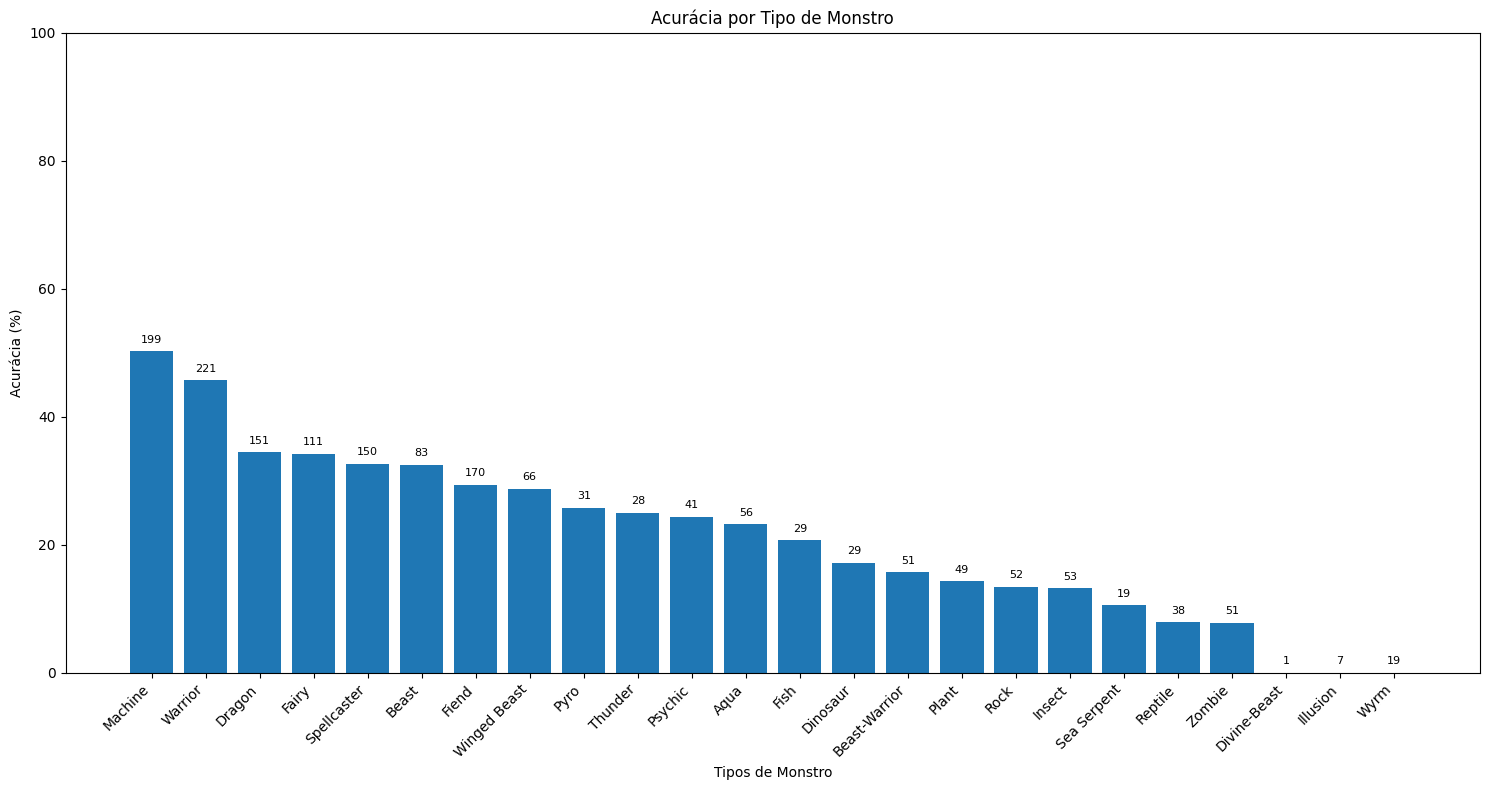


Acurácia geral: 30.67%


In [33]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Relatório de classificação
class_names = label_encoder.classes_
print("Relatório de Classificação:")
print(classification_report(all_labels, all_predictions, target_names=class_names))

# Matriz de confusão com Plotly
cm = confusion_matrix(all_labels, all_predictions)

# Normaliza a matriz para porcentagens
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Cria a matriz de confusão interativa
fig_cm = ff.create_annotated_heatmap(
    z=cm_normalized,
    x=list(class_names),
    y=list(class_names),
    annotation_text=[[f'{cm[i][j]}<br>({cm_normalized[i][j]:.1f}%)' 
                     for j in range(len(class_names))] 
                     for i in range(len(class_names))],
    colorscale='Blues',
    showscale=True,
    hovertemplate='Verdadeiro: %{y}<br>Predito: %{x}<br>Contagem: %{text}<extra></extra>'
)

fig_cm.update_layout(
    title='Matriz de Confusão - Classificador Yu-Gi-Oh',
    title_x=0.5,
    xaxis_title='Predito',
    yaxis_title='Verdadeiro',
    width=800,
    height=800,
    font=dict(size=10)
)

# Rotaciona labels do eixo x para melhor legibilidade
fig_cm.update_xaxes(tickangle=45)

fig_cm.show()

# Salvando o modelo
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': label_encoder,
    'num_classes': num_classes
}, 'yugioh_monster_classifier.pth')

print("Modelo salvo como 'yugioh_monster_classifier.pth'")

# Função para predição em novas imagens
def predict_monster_type(image_path, model, label_encoder, transform, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        _, predicted = torch.max(outputs, 1)
        
    predicted_class = label_encoder.inverse_transform([predicted.cpu().numpy()[0]])[0]
    confidence = probabilities.max().item() * 100
    
    return predicted_class, confidence

# Exemplo de uso da função de predição
# predicted_type, confidence = predict_monster_type('caminho/para/nova/imagem.jpg', 
#                                                   model, label_encoder, val_transform, device)
# print(f'Tipo predito: {predicted_type} (Confiança: {confidence:.2f}%)')

# Análise das predições por classe
class_accuracy = []
for i, class_name in enumerate(class_names):
    class_mask = np.array(all_labels) == i
    if np.sum(class_mask) > 0:
        class_pred = np.array(all_predictions)[class_mask]
        accuracy = np.mean(class_pred == i) * 100
        class_accuracy.append((class_name, accuracy, np.sum(class_mask)))

class_accuracy.sort(key=lambda x: x[1], reverse=True)

print("\nAcurácia por classe:")
for class_name, acc, count in class_accuracy:
    print(f'{class_name}: {acc:.2f}% ({count} amostras)')

# Visualização da acurácia por classe
classes, accuracies, counts = zip(*class_accuracy)
plt.figure(figsize=(15, 8))
bars = plt.bar(range(len(classes)), accuracies)
plt.xlabel('Tipos de Monstro')
plt.ylabel('Acurácia (%)')
plt.title('Acurácia por Tipo de Monstro')
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
plt.ylim(0, 100)

for i, (bar, count) in enumerate(zip(bars, counts)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{count}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nAcurácia geral: {100 * np.mean(np.array(all_predictions) == np.array(all_labels)):.2f}%")
